In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

### DNA Sequences 101 (best docked)

First, convert the tpr file to include only protein and DNA topologies


```bash
gmx convert-tpr -s prod_dna_sequence_101_peptide_model_0.tpr -n ../dna_sequence_101_peptide_model_0_water_ion.ndx -o prod_dna_sequence_101_peptide_model_0_compact_compact.tpr
```

Select 'Protein_DNA' and repeat for all trajectories.

In [2]:
import pandas as pd

#Read all the trajectories
dna_101_ku04amp01_model0= mda.Universe('molecular_dynamics/dna_sequence_101_peptide_model_0/sys_prod/prod_dna_sequence_101_peptide_model_0_compact_compact.tpr', 'molecular_dynamics/dna_sequence_101_peptide_model_0/sys_prod/prod_dna_sequence_101_peptide_model_0_compact_compact.xtc')


sims = {'101':dna_101_ku04amp01_model0}



## RMSD Calculation

RMSD of DNA

  0%|          | 0/5001 [00:00<?, ?it/s]

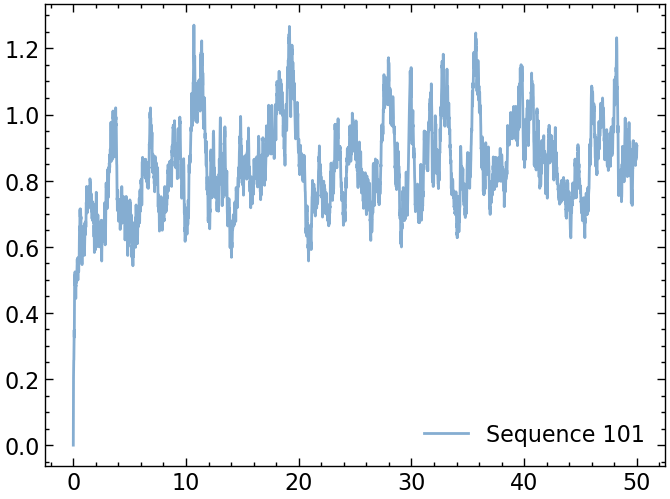

In [3]:
from MDAnalysis.analysis import rms

dfs = {}

for key, value in sims.items():
    R = rms.RMSD(value,  # universe to align
        value,  # reference universe or atomgroup
        select='nucleic',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    plt.plot(times/1000, rmsd/10, alpha=0.5, label=f'Sequence {key}')
    df_rmsd = pd.DataFrame(np.vstack((times, rmsd)).T, columns=["DNA rmsd time", "DNA rmsd"])
    dfs[key] = df_rmsd

plt.legend()


RMSD of Peptide

  0%|          | 0/5001 [00:00<?, ?it/s]

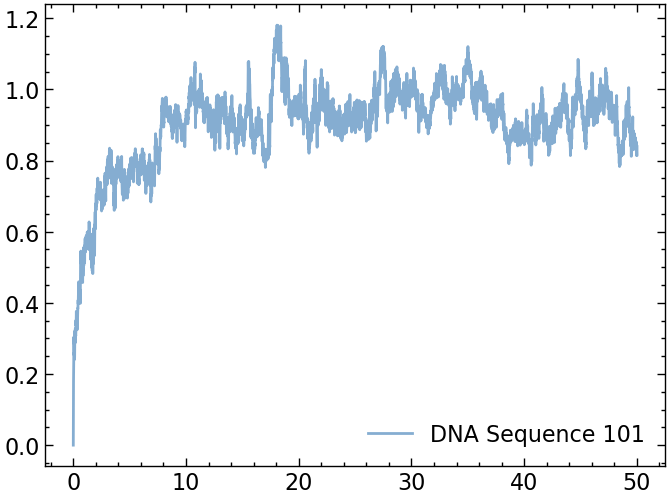

In [4]:
from MDAnalysis.analysis import rms

for key, value in sims.items():
    R = rms.RMSD(value,  # universe to align
        value,  # reference universe or atomgroup
        select='protein',  # group to superimpose and calculate RMSD
        ref_frame=0)  # frame index of the reference

    R.run(verbose=True)
    times = R.results.rmsd[:,1]
    rmsd = R.results.rmsd[:,2]
    plt.plot(times/1000, rmsd/10, alpha=0.5, label=f'DNA Sequence {key}')
    dfs[key] = pd.concat([dfs[key], pd.DataFrame(np.vstack((times, rmsd)).T, columns=["Peptide rmsd time", "Peptide rmsd"])], axis=1)

plt.legend()


## Radius of Gyration Calculation

$R_g$ of the DNA

  0%|          | 0/5001 [00:00<?, ?it/s]

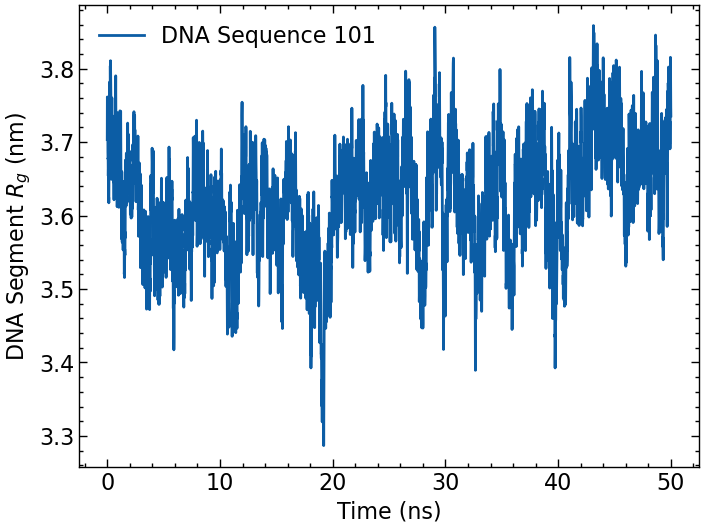

In [5]:
from tqdm.notebook import tqdm


for key, value in sims.items():
    
	group = value.select_atoms('nucleic')		# change the atom selection for your specific system

	Frame = []
	times = []
	Rgyr = []
	for ts in tqdm(value.trajectory):
		Frame.append(ts.frame)
		times.append(value.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
	dfs[key] = pd.concat([dfs[key], pd.DataFrame(Rgyrc_table, columns=["DNA Rgyr frame", "DNA Rgyr time (ps)", "DNA Rgyr (A)"])], axis=1)
	plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label=f'DNA Sequence {key}')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'DNA Segment $R_g$ (nm)')
plt.show()

$R_g$ of peptide

  0%|          | 0/5001 [00:00<?, ?it/s]

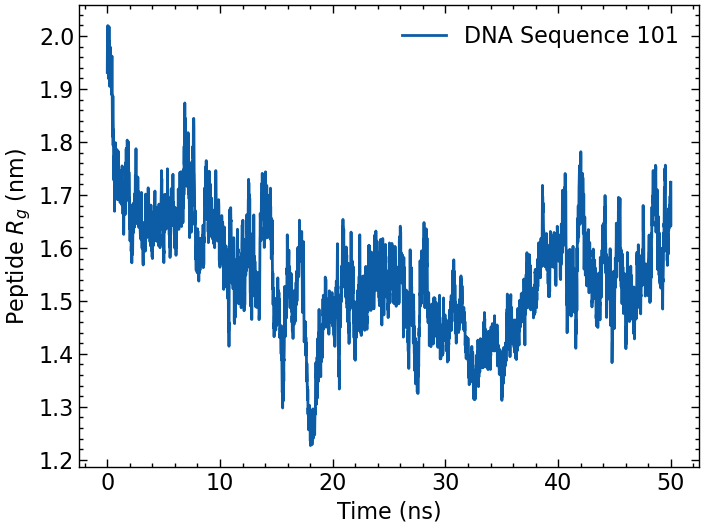

In [6]:
from tqdm.notebook import tqdm


for key, value in sims.items():
    
	group = value.select_atoms('protein')		# change the atom selection for your specific system

	Frame = []
	times = []
	Rgyr = []
	for ts in tqdm(value.trajectory):
		Frame.append(ts.frame)
		times.append(value.trajectory.time)
		Rgyr.append(group.radius_of_gyration())

	Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
	dfs[key] = pd.concat([dfs[key], pd.DataFrame(Rgyrc_table, columns=["Peptide Rgyr frame", "Peptide Rgyr time (ps)", "Peptide Rgyr (A)"])], axis=1)
	plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, label=f'DNA Sequence {key}')

plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel(r'Peptide $R_g$ (nm)')
plt.show()

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/5001 [00:00<?, ?it/s]

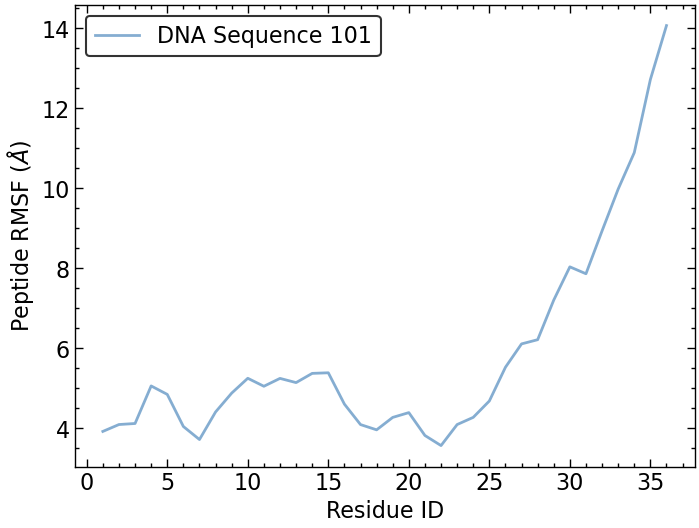

In [7]:
from tqdm.notebook import tqdm

for key, value in sims.items():
    
    c_alphas_c = value.select_atoms('protein and backbone and name CA')
	
    R_c = rms.RMSF(c_alphas_c).run(verbose=True)
    plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5, label=f'DNA Sequence {key}')
    dfs[key] = pd.concat([dfs[key], pd.DataFrame(np.vstack((c_alphas_c.resids, R_c.results.rmsf)).T, columns=["Peptide Resids", "RMSF (A)"])], axis=1)

plt.xlabel('Residue ID')
plt.ylabel(r'Peptide RMSF $\left(\AA\right)$')
leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)

## Hydrogen Bond Analysis

### H-bond parameters
  - *d_h_cutoff* (Å) [1.2] : Distance cutoff used for finding donor-hydrogen pairs
  - *d_a_cutoff* (Å) [3.0] : Distance cutoff for hydrogen bonds. This cutoff refers to the D-A distance.
  - *d_h_a_angle_cutoff* (degrees) [150] : D-H-A angle cutoff for hydrogen bonds.

In [9]:
nucleotides = ["DA", "DG", "DT", "DC"]
amino_acids = [
    "ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU",
    "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR"
]

Note that we're selecting DNA and protein, so the selections need not be updated with each frame. Setting `update_selections=False` drastically speeds up the hbonds run.

**Note** The selections need to be super precise and atom specific, otherwise there will be many false positives during the hydrogen bond detection, as it will try to 'detect' hydrogen bonds for every atom in the selection, even ones that aren't electronegative enough to be donors and/or acceptors. So selections for donors and acceptors should be obtained with the `guess_` methods.

Note that there are virtually no statistically significant occurrences of hydrogen bonds where DNA is the donor and peptide is the acceptor. I checked and got nothing

In [10]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

hbonds_prot_DNA_dict = {}

for key, u in sims.items(): 
    nucleic = u.select_atoms('resname DNA')
    protein = u.select_atoms('protein')
    num_residues = len(protein.residues)
    hbonds_prot_DNA = HBA(universe=u,
        update_selections=False
        )

    hbonds_prot_DNA.donors_sel = hbonds_prot_DNA.guess_donors("protein")
    hbonds_prot_DNA.hydrogens_sel = hbonds_prot_DNA.guess_hydrogens("protein")
    hbonds_prot_DNA.acceptors_sel = hbonds_prot_DNA.guess_acceptors("not protein")

    hbonds_prot_DNA.run(verbose=True)  
    hbonds_prot_DNA_dict[key] = hbonds_prot_DNA 

  0%|          | 0/5001 [00:00<?, ?it/s]

The fraction of total trajectory frames where each type of hydrogen bond is formed (bond probability) is likely more informative than the total number over the trajectory. This can be calculated for each hydrogen bond type as follows:

In [11]:
from tqdm.notebook import tqdm
from collections import Counter
from tabulate import tabulate

all_hbonds = {}

for key, hbonds_prot_DNA in hbonds_prot_DNA_dict.items():

    bonds = []
    u = sims[key]
    for hbond in tqdm(hbonds_prot_DNA.results.hbonds):
        frame, donor_ix, hydrogen_ix, acceptor_ix = hbond[:4].astype(int)
        u.trajectory[frame]
        donor_resname = u.atoms[donor_ix].resname
        acceptor_resname = u.atoms[acceptor_ix].resname
        if donor_resname in amino_acids and acceptor_resname in nucleotides:#Exclude DNA donors
            donor_resid = u.atoms[donor_ix].resid
            donor_resname = u.atoms[donor_ix].resname
            donor_atom = u.atoms[donor_ix].name
            hydrogen_atom = u.atoms[hydrogen_ix].name
            acceptor_resid = u.atoms[acceptor_ix].resid
            acceptor_resname = u.atoms[acceptor_ix].resname
            acceptor_atom = u.atoms[acceptor_ix].name
            bonds.append(f'{donor_resid}-{donor_resname} ({donor_atom}:{hydrogen_atom}⋯{acceptor_atom}) {acceptor_resid}-{acceptor_resname}')
        
    bonds_dict = dict(Counter(bonds))
    all_hbonds[key] = bonds_dict



  0%|          | 0/366566 [00:00<?, ?it/s]

In [12]:
cutoff = 0.1
hbond_counts_dict = {}
for key, donors_dict in all_hbonds.items():
    print(f"DNA Sequence {key}")
    hbonds_prot_DNA = hbonds_prot_DNA_dict[key]
    table_data = [[donor, count/hbonds_prot_DNA.n_frames] for donor, count in donors_dict.items()]
    table_data.sort(key=lambda x: int(x[0].split('-')[0]))
    hbond_counts_dict[key] = pd.DataFrame(table_data, columns=["Bond Type", "Hydrogen Bond Occupancy"])
    # Filter out rows with a Hydrogen Bond Probability lower than 0.01
    hbond_counts_dict[key] = hbond_counts_dict[key][hbond_counts_dict[key]["Hydrogen Bond Occupancy"] >= cutoff]
    table_data = hbond_counts_dict[key].values.tolist()
    print(tabulate(table_data, headers=["Bond Type", "Hydrogen Bond Occupancy"], tablefmt='markdown'))
    print("-----------------------------------------------")



DNA Sequence 101
Bond Type                      Hydrogen Bond Occupancy
---------------------------  -------------------------
6-SER (OG:HG⋯O1P) 66-DG                       0.271746
9-ARG (NH2:HH22⋯O1P) 89-DT                    0.121376
16-SER (OG:HG⋯O1P) 64-DC                      0.30094
18-ARG (NE:HE⋯O1P) 90-DC                      0.422316
18-ARG (NH2:HH21⋯O3') 89-DT                   0.34993
21-GLN (NE2:HE21⋯O3') 90-DC                   0.180164
21-GLN (NE2:HE21⋯O1P) 91-DC                   0.143571
22-THR (OG1:HG1⋯O2P) 90-DC                    0.716257
24-SER (OG:HG⋯O2P) 91-DC                      0.203959
-----------------------------------------------


In [13]:
# Get the union of all residues across dataframes
all_residues = set()
for df in hbond_counts_dict.values():
    all_residues.update(df["Bond Type"].tolist())

# Define a sorting key that sorts by the numeric part then the residue name
def sort_key(res):
    num, resname = res.split('-', 1)
    return (int(num), resname)

sorted_residues = sorted(all_residues, key=sort_key)

# Reindex each DataFrame so they share the same sorted residues,
# padding missing entries with NaN
for key, df in hbond_counts_dict.items():
    df_indexed = df.set_index("Bond Type")
    df_reindexed = df_indexed.reindex(sorted_residues).reset_index()
    hbond_counts_dict[key] = df_reindexed

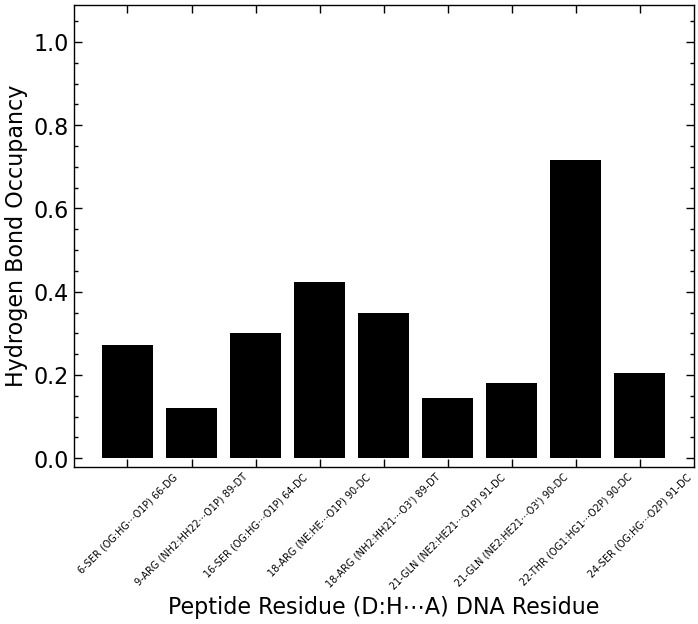

In [18]:
# Extract donors and counts from table_data
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
fig, ax = plt.subplots()
colors = ['black']
alphas = [1.0]
for i, (key, df) in enumerate(hbond_counts_dict.items()):
    ax.bar(df["Bond Type"], df["Hydrogen Bond Occupancy"], alpha=alphas[i], label=f'DNA Sequence {key}', color=colors[i])
    ax.set_xlabel("Peptide Residue (D:H⋯A) DNA Residue")
    ax.set_ylabel("Hydrogen Bond Occupancy")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(-0.02,1.09)
    ax.xaxis.minorticks_off()
    #ax.legend(loc="upper right",frameon=True, fancybox=True, shadow=False)
    ax.tick_params(axis='x', labelsize=7)
plt.savefig('dna_sequence_seq_101_hbond_occupancies.png', dpi=600)
plt.show()

So, the best bonds are:

1. For Seq 101: 22-THR (OG1:HG1⋯O2P) 90-DC, Occ: 0.716257


Sequence 101 definitely shows the highest bond probability. The others are less, though not very far behind.

### Combined output 

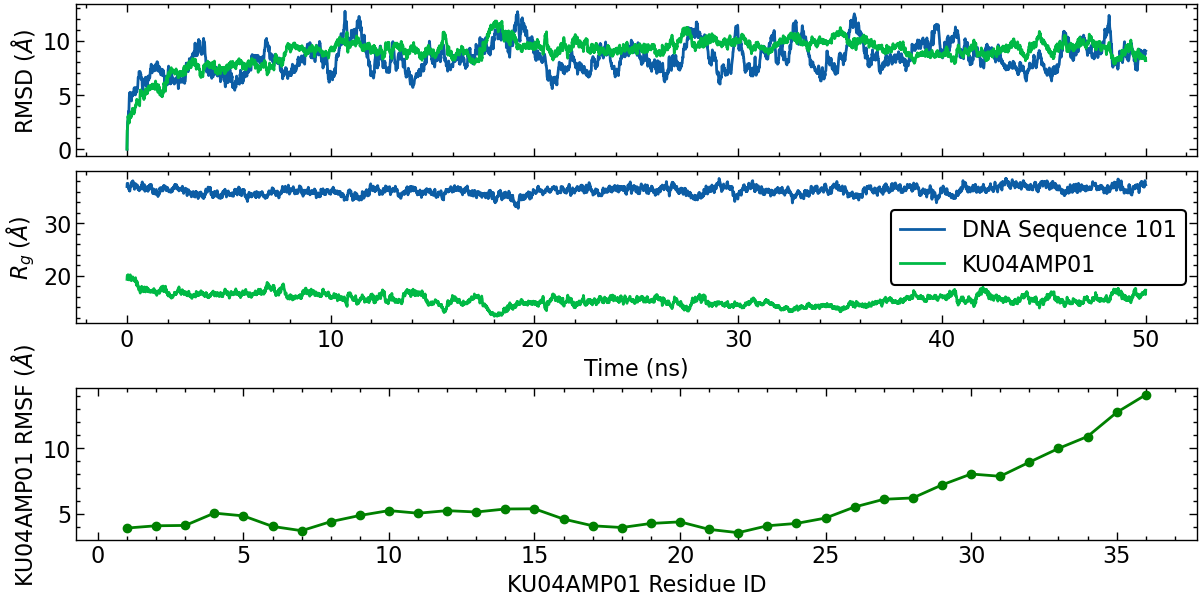

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 6), constrained_layout=True)
for key, df in dfs.items():
    # Panel 1:  RMSD vs Time
    axs[0].plot(df["DNA rmsd time"]/1000, df["DNA rmsd"], label=f"DNA Sequence {key}")
    axs[0].set_ylabel(r"RMSD $\left(\AA\right)$")
    axs[0].set_xticklabels([])
    #axs[0].legend()
    
    axs[0].plot(df["Peptide rmsd time"]/1000, df["Peptide rmsd"], label=f"KU04AMP01")
    axs[0].set_xticklabels([])
    #axs[1].legend()

    # Panel 2: Radius of Gyration  vs Time
    axs[1].plot(df["DNA Rgyr time (ps)"] / 1000, df["DNA Rgyr (A)"], label=f"DNA Sequence {key}")
    axs[1].set_ylabel(r"$R_g\; \left(\AA\right)$")
    #axs[1].legend()
    
    axs[1].plot(df["Peptide Rgyr time (ps)"] / 1000, df["Peptide Rgyr (A)"], label=f"KU04AMP01")
    axs[1].set_xlabel("Time (ns)")
    #axs[3].legend()

    # Panel 3: RMSF vs Residues
    # Only non-null rows are plotted (RMSF was added for about 36 residues)
    rmsf_data = df[["Peptide Resids", "RMSF (A)"]].dropna()
    axs[2].plot(rmsf_data["Peptide Resids"], rmsf_data["RMSF (A)"], marker='o', linestyle='-', label=f"KU04AMP01", color='green')
    axs[2].set_xlabel("KU04AMP01 Residue ID")
    axs[2].set_ylabel(r"KU04AMP01 RMSF $\left(\AA\right)$ ")
    
    leg = axs[1].legend(loc='center right', frameon=True, fancybox=True, shadow=False)
    leg.get_frame().set_alpha(1.0)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(1.5)    
plt.savefig('dna_sequence_seq_101_peptide_model_0.png', dpi=600)

plt.show()

So, the best bonds are:

1. For Seq 101: 22-THR (OG1:HG1⋯O2P) 90-DC, Occ: 0.716257
2. For Seq 85: 9-ARG (NE:HE⋯O1P) 76-DG, Occ: 0.358328 AND 9-ARG (NH2:HH21⋯O2P) 76-DG, Occ: 0.381124
3. For Seq 72: 9-ARG (NE:HE⋯O1P) 79-DC Occ: 0.64767


Sequence 101 definitely shows the highest bond probability. The others are less, though not very far behind.

## Hydrogen Bond lifetimes via correlation analysis

For the h-bond, we plot 

\begin{equation*}
C^{ij}_x(t)=\left\langle\frac{h_{i j}\left(t_0\right) h_{i j}\left(t_0+t\right)}{h_{i j}\left(t_0\right)^2}\right\rangle_{t_0}
\end{equation*}

where 

\begin{equation*}
h_{ij} = \begin{cases}
1 & \text{If hbond: } i \to j\\
0 & \text{otherwise }
\end{cases}
\end{equation*}

The subscript in $C_x$, $x$, can be either $C$ (continuous) or $I$ (intermittent). When $x=C$, a bond, once broken, is assumed to never form again even if conditions are optimal, whereas when $x=I$, bond formation is counted regardless of history. Thus, a low $C_C(t)$ and high $C_I(t)$ indicates the dominance of intermittent hydrogen bonds. The curves are fit to exponential decays to yield bond life times.


In this case, no intermittent bonds were detected, so the bonds are continuous.

Finally, we can estimate the lifetime by fitting to exponential function (see references in MDAnalysis docs)

\begin{equation*}
C_I(t) = A_1 e^{-t/\tau_1} + A_2 e^{-t/\tau_2} 
\end{equation*}

The bond lifetime is given by the numerical integration

\begin{equation*}
\tau_I = \int^\infty_0 C_I(t) \mathrm{d}t.
\end{equation*}

In [3]:
hbl_dict = {}


### First Hydrogen Bond
Seq 101: 22-THR (OG1:HG1⋯O2P) 90-DC

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

bondname = "Seq 101: 22-THR (OG1:HG1⋯O2P) 90-DC"

universe = sims['101']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 22 and resname THR and name OG1",
        hydrogens_sel="protein and resid 22 and resname THR and name HG1",
        acceptors_sel="nucleic and resid 90 and resname DC and name O2P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, protein and resid 22 and resname THR and name OG1, and Acceptor, nucleic and resid 90 and resname DC and name O2P.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, protein and resid 22 and resname THR and name OG1, and Acceptor, nucleic and resid 90 and resname DC and name O2P.
  warnings.warn(


In [6]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row


### Second Hydrogen Bond
Seq 85: 9-ARG (NE:HE⋯O1P) 76-DG

In [7]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

bondname = "Seq 85: 9-ARG (NE:HE⋯O1P) 76-DG"

universe = sims['85']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 9 and resname ARG and name NE",
        hydrogens_sel="protein and resid 9 and resname ARG and name HE",
        acceptors_sel="nucleic and resid 76 and resname DG and name O1P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, protein and resid 9 and resname ARG and name NE, and Acceptor, nucleic and resid 76 and resname DG and name O1P.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, protein and resid 9 and resname ARG and name NE, and Acceptor, nucleic and resid 76 and resname DG and name O1P.
  warnings.warn(


In [8]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row


### Third Hydrogen Bond
9-ARG (NH2:HH21⋯O2P) 76-DG

In [11]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

bondname = "Seq 85: 9-ARG (NH2:HH21⋯O2P) 76-DG"

universe = sims['85']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 9 and resname ARG and name NH2",
        hydrogens_sel="protein and resid 9 and resname ARG and name HH21",
        acceptors_sel="nucleic and resid 76 and resname DG and name O2P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

In [12]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row

### Fourth Hydrogen Bond
Seq 72: 9-ARG (NE:HE⋯O1P) 79-DC

In [14]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

bondname = "Seq 72: 9-ARG (NE:HE⋯O1P) 79-DC"

universe = sims['72']

# Perform hydrogen bond analysis
hbonds = HBA(universe,
        donors_sel="protein and resid 9 and resname ARG and name NE",
        hydrogens_sel="protein and resid 9 and resname ARG and name HE",
        acceptors_sel="nucleic and resid 79 and resname DC and name O1P",
        update_selections=False
    ).run(verbose=True)


  0%|          | 0/5001 [00:00<?, ?it/s]

/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:742: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, protein and resid 9 and resname ARG and name NE, and Acceptor, nucleic and resid 79 and resname DC and name O1P.
  warnings.warn(
/home/daneel/gitrepos/mdanalysis/package/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, protein and resid 9 and resname ARG and name NE, and Acceptor, nucleic and resid 79 and resname DC and name O1P.
  warnings.warn(


In [16]:
from scipy.optimize import curve_fit
from scipy.integrate import quad

tau_max = 60
stride = 3


# Fit exponential decay
def hbond_corr(x, A1, tau1, A2, tau2):
    return A1 * np.exp(-x/tau1) + A2 * np.exp(-x/tau2)


def calculate_lifetime(hbond):
    taus, hbl = hbond.lifetime(
        tau_max=tau_max,
    )
    return np.vstack((taus,hbl)).T

# Calculate lifetimes in parallel
hbl = calculate_lifetime(hbonds)
taus, hbl = hbl[:, 0], hbl[:, 1]
times = taus * universe.trajectory.dt/1000


popt, pcov = curve_fit(hbond_corr, times, hbl, p0=[1, 0.01, 1, 1], maxfev=15000)
fit_times = np.linspace(times[0], times[-1], 100)
fit_hbl = hbond_corr(fit_times, *popt)
tau_i, tau_err = quad(hbond_corr, fit_times[0], fit_times[-1], args=tuple(popt))
tau_i_ps = round(1000 * tau_i, 1) if tau_i < 1 else round(tau_i) 


new_row = {
    'Bond Name': [bondname],
    'Times': [times],
    'hbl': [hbl],
    'Fit Times': [fit_times],
    'Fit hbl': [fit_hbl],
    'Tau_i_ps': [tau_i_ps]
}

hbl_dict[bondname] = new_row

### Plot all Hydrogen Bond Lifetimes 

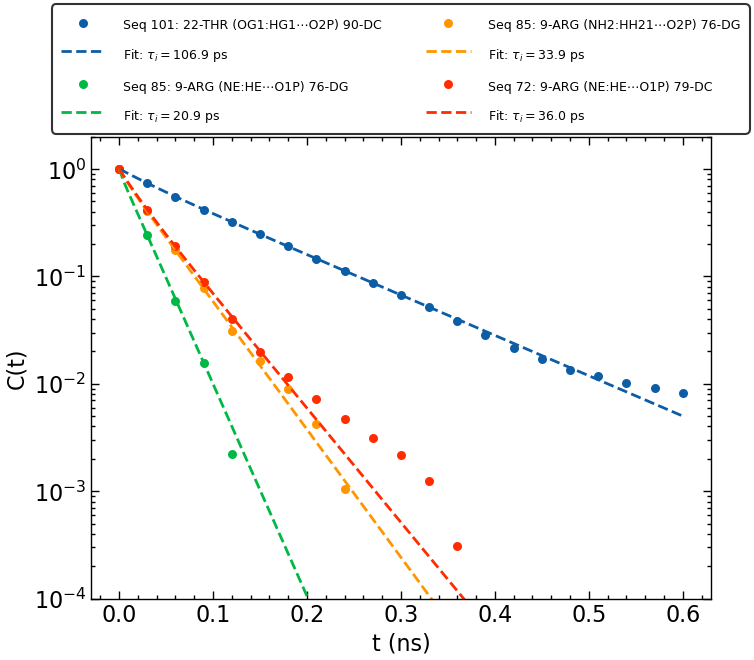

In [39]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])


for key, value in hbl_dict.items():
    plt.scatter(value['Times'][0][::stride], value['hbl'][0][::stride], label= key, lw=2, s=20)
    plt.plot(value['Fit Times'][0], value['Fit hbl'][0], ls='--', lw=2, label=f'Fit: $\\tau_i = {value["Tau_i_ps"][0]}$ ps')

plt.xlabel('t (ns)')
plt.ylabel('C(t)')
plt.yscale('log')
plt.ylim(1e-4, 2)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.31), ncols=2, frameon=True, fancybox=True, shadow=False)
#leg = plt.legend(loc='lower left',
#                ncols=2, frameon=True, fancybox=True, shadow=False)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.5)
plt.setp(leg.get_texts(), fontsize=9)
plt.savefig("hbond_lifetimes_best_docked.png", dpi=600)
plt.show()

## Principal Component Analysis 

We will do the PCA using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.


### PCA via GROMACS tools

Go to the `sys_prod` directory, then create an index for DNA, backbone 

`gmx make_ndx -f ../dna_sequence_101_peptide_model_0_water_ion.gro -o dna_sequence_101_peptide_model_0_pca.ndx` Choose backbone OR DNA

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

Then, generating the eigenvectors


`gmx covar -s prod_start.pdb -f prod_dna_sequence_101_peptide_model_0_compact_compact.xtc -o prod_dna_sequence_101_peptide_model_0_eigenvalues.xvg -v prod_dna_sequence_101_peptide_model_0_eigenvectors.trr -xpma prod_dna_sequence_101_peptide_model_0_covapic.xpm -n dna_sequence_101_peptide_model_0_pca.ndx`
Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1, pc2 and pc3 files


`gmx anaeig -f prod_dna_sequence_101_peptide_model_0_compact_compact.xtc -s prod_start.pdb -v prod_dna_sequence_101_peptide_model_0_eigenvectors.trr -last 1 -proj prod_dna_sequence_101_peptide_model_0_pc1.xvg -n dna_sequence_101_peptide_model_0_pca.ndx`

`gmx anaeig -f prod_dna_sequence_101_peptide_model_0_compact_compact.xtc -s prod_start.pdb -v prod_dna_sequence_101_peptide_model_0_eigenvectors.trr -first 2 -last 2 -proj prod_dna_sequence_101_peptide_model_0_pc2.xvg -n dna_sequence_101_peptide_model_0_pca.ndx`

`gmx anaeig -f prod_dna_sequence_101_peptide_model_0_compact_compact.xtc -s prod_start.pdb -v prod_dna_sequence_101_peptide_model_0_eigenvectors.trr -first 3 -last 3 -proj prod_dna_sequence_101_peptide_model_0_pc3.xvg -n dna_sequence_101_peptide_model_0_pca.ndx`



Use these three xvg files (`prod_dna_sequence_101_peptide_model_0_pc{1,2,3}.xvg`) to generate the following plots.

Finally, I ran the following commands to project the trajectory to the PCA components and then visualize them.

`gmx anaeig -f prod_dna_sequence_101_peptide_model_0_compact_compact.xtc -s prod_start.pdb -extr extreme_pc.pdb -v prod_dna_sequence_101_peptide_model_0_eigenvectors.trr -first 1 -last 3 -nframes 80 -n dna_sequence_101_peptide_model_0_pca.ndx`

Then load the three pdbs of the projections along each axis into pymol and made the following observations. The image corroborates the PCA FEL plots in that the ligand shoots out of the protein and leaves.


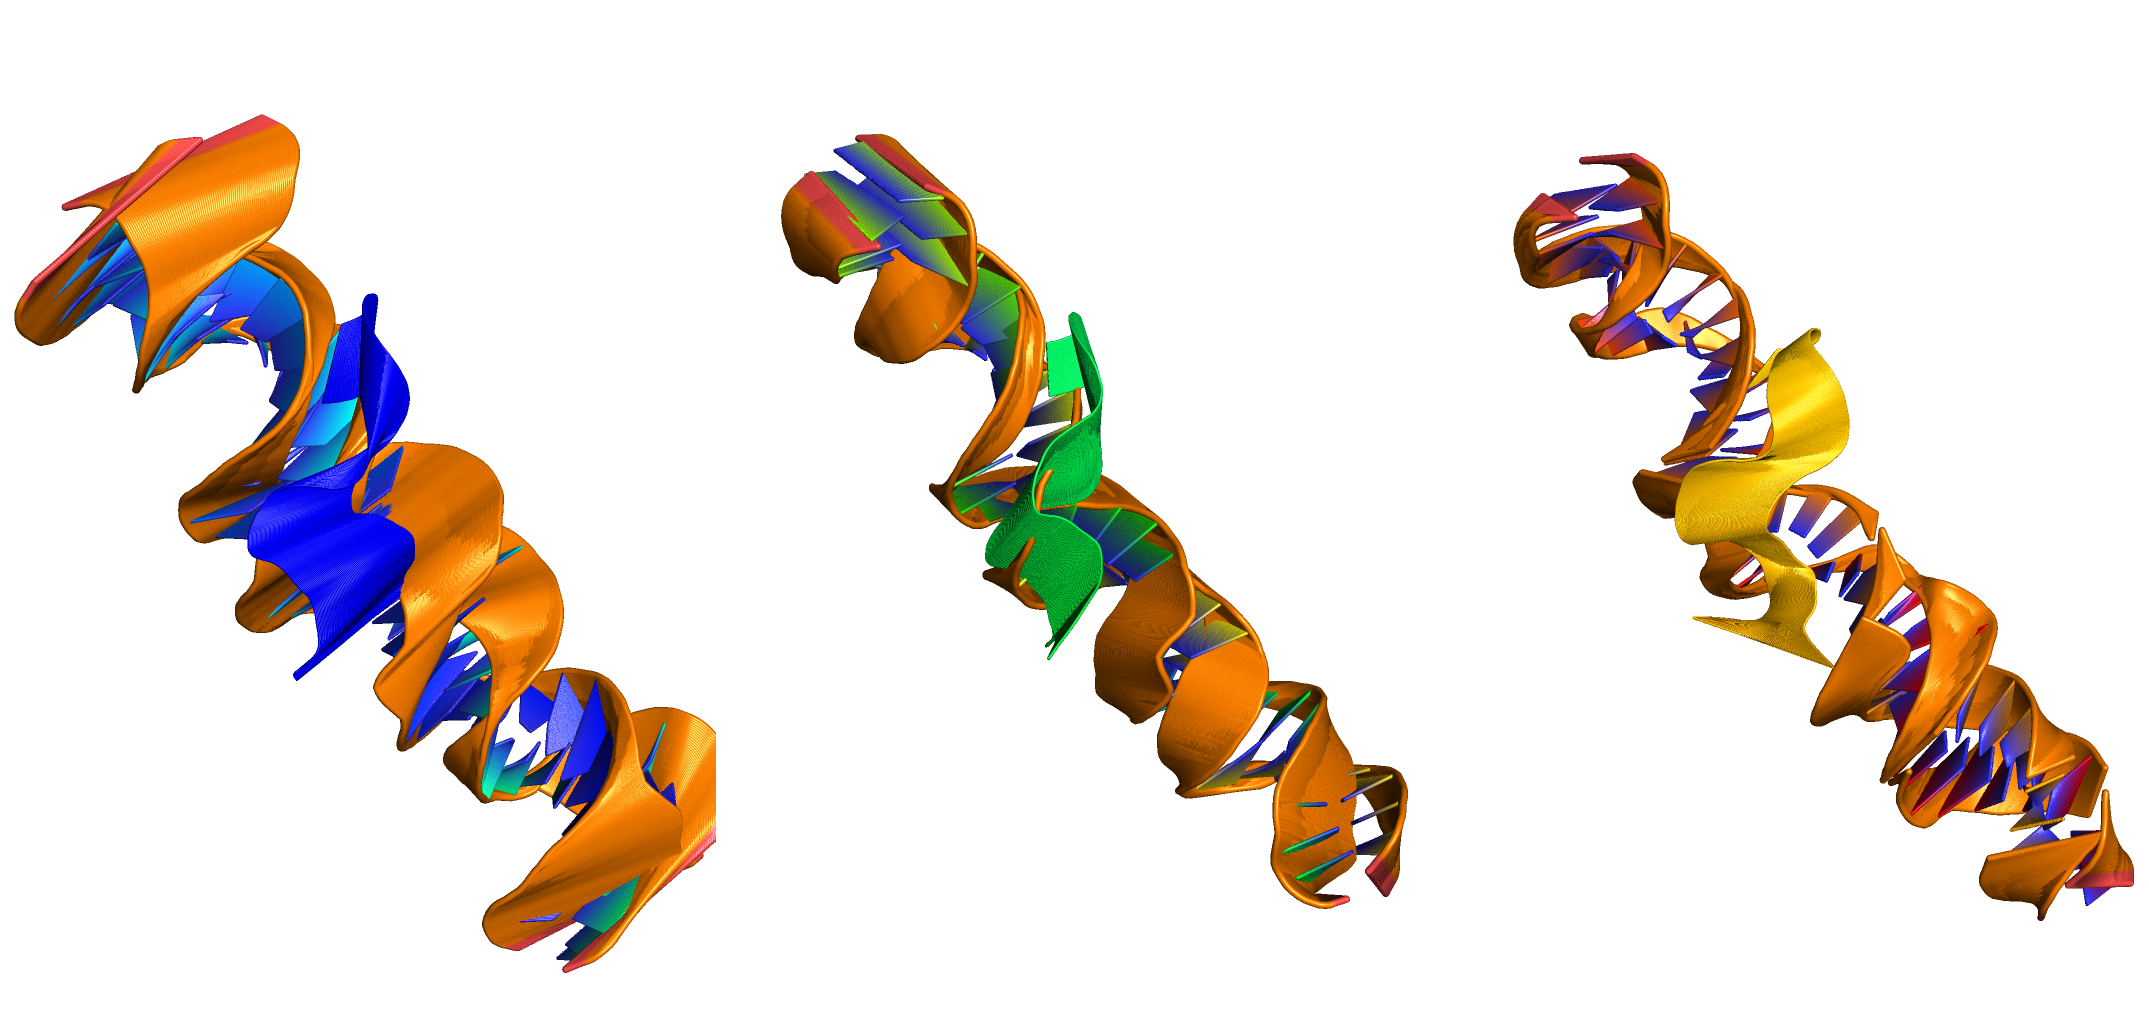

In [2]:
from IPython.display import Image
Image("dna_seq_101_prod_pc1pc2pc3.png")